## Linear Conjugate Gradient Method (CGM)

The linear conjugate gradient method is used for solving a linear system of equations $$Ax = b$$
where $A$ is an $n\times n$ symmetric positive definite matrix.  

Such an $x$ can be determined by solving the equivalent convex minimization problem $$ \min_{x\in\mathbb{R}^n} \phi(x) = \frac{1}{2} x^T A x - b^T x.$$  


Thus, we can interpret the iterative Linear Conjugate Gradient algorithm as a technique for solving linear systems or as a means for minimizing convex quadratic functions.  

Note, that $\nabla \phi$ is the residual of the linear system, i.e. $$\nabla \phi (x) = Ax - b = r(x),$$

and for a given $x_k$ we say $r_k = r(x_k)$.

The CGM generates a _conjugacy_ set of nonzero vectors $\{p_0, p_1,...,p_l\}$ in an economical fashion, a very remarkable property of the method.
Having a set of vectors conjugate to $A$ will allow us to minimize $\phi$ in $n$ steps by successively minimizing it along the individual directions in the conjugate set.  

***def:*** A set of nonzeros vectors $\{p_0, p_1,...,p_l\}$ is said to be _conjugate_ to a SPD matrix $A$ if $p^T_iAp_j = 0 ~ \forall i\not = j$.  


Let $x_o \in \mathbb{R}^n$ be a given starting point, and let $\{p_0, p_1,...,p_l\}$ be a set of conjugate directions with respect to $A$.
Then we define the sequence $(x_k)$ by 

$$x_{k+1} = x_k + \alpha_k p_k,$$  
where $\alpha_k$ is one-dimensional minimizer of $\phi$ given by  
$$\alpha_k = -\frac{r_k^T p_k}{p_k^TAp_k}.$$  

&nbsp;  
***Theorem 5.1:*** For any $x_0 \in \mathbb{R}^n$ the sequence $(x_k)$ converges to the global minimizer solution $x^*$ in at most n steps.  
+ The recursively generated sequence $(x_k)$ is reffered to as the **conjugate direction algorithm**.  

&nbsp;  
***Theorem 5.2:*** For any starting point $x_0 \in \mathbb{R}^n$ and suppose $(x_k)$ is generated using the conjugate direction algorithm. Then  

$$r_k^T p_i = 0 ~ \forall i \in [0, k-1],$$  

and $x_k$ is the minimizer of $\phi(x) = \frac{1}{2} x^T A x - b^T x$ over the set $\{x ~|~ x = x_o + \text{span}\{p_0, p_1,..., p_{k-1}\} \}$  
+ This asserts that the current residual $r_k$ is orthogonal to all previous search directions, a crucial property to the algorithms utility.


&nbsp;  

If the Hessian of $\phi$ happens to be a diagonal (note, $\nabla^2 \phi = A$), then the set of basis vectors will suffice for a conjugate direction set.
When this property doesn't hold, the eigenvectors are both conjugate and orthogonal to the span of $A$ but this is generally an expensive computation.
We could drop the orthogonality requirement and modify the Gram-Schmidt algorithm to produce a conjugate set, but that has trade-off's in terms of space complexity.  


A beter approach would be to use the **CGM**, which is both a conjugate direction method and a procedure for generating a conjugate set.
The CGM only requires knowledge of the previous conjugate vector, namely, given p_{k-1} it can produce a new vector $p_k$ such that $p_{j}^T A p_k = 0$ for $j < k$.
This is done, by picking the next conjugate vector by a linear combination of the residual $r_k$ (which is $\nabla \phi(x_k)$ and the previous conjugate direction, i.e.  

$$p_k = - r_k + \beta_k p_{k-1},$$

where the scalar $\beta_k$ is to be determined by the requirement that $p_{k-1}$ and $p_k$ must be conjugate with respect to A.
By premultiplying $p_{k-1}^T A$ to both sides of the previous equation we can solve for $\beta_k$ as  

$$\beta_k = \frac{r_k^T A p_{k-1}}{p_{k-1}^T A p_{k-1}}.$$

Lastly, we can safely choose the initial direction $p_o$ by the fact that $\phi$ is convex, namely, $p_0 = \nabla \phi(x_0)$ where $x_0$ is the initial guess.

We now can specify a preliminary conjugate gradient method! But always remeber that it is not the gradients that are conjugate, rather, the search directions that are conjugate!

**function cgm_linear($A$, $b$, $x$, $\epsilon$):** Parameters are $A \in \mathbb{R}^{n \times n}$ SPD, $x, b \in \mathbb{R^n}$, and $\epsilon$ is a specified precision. The algorithm terminates when it has identified an global minimum or more than $n$ iterations have occured. It returns $x^*$, the determined global minimizer. 

&nbsp;  







In [4]:
using LinearAlgebra

# used throughout notebook to terminate algorithms for insufficient progress
isdisaster(k, maxItr) = k < maxItr || error("DISASTER somewhere & reached maximum number of iterations")

function cgm_linear(A, b, x, eps) 
    r = A*x-b
    p = -r
    k  = 0
    while norm(r) > eps
        x -= ((r'*p) / (p'*A*p)) * p
        r = A*x - b
        p = -r + ((r'*A*p) / (p'*A*p)) * p  
        isdisaster(k+=1, length(x))
    end
    println("Number of iterations k = ", k)
    x
end


# perform some basic testing of cgm_linear
n = 1000
A1 = Diagonal(rand(n))
b1 = rand(n)
x1 = ones(n)
println("A1 symmetric: ", issymmetric(A1), ", A1 positive definite: ", isposdef(A1))
x_star = cgm_linear(A1, b1, x1, 10^(-3))
println("Euclidean error: ", norm(A1\b1 - x_star), "\n")


# perform another test with a dense matrix.
temp = rand(n,n)
A2 = 0.5*(temp + temp') # ensures A2 is symmetric, we scale to ensure the elements are less than 1
A2 += n*I # ensures A2 is diagonally dominant, and since it is symmetric, A2 is now SPD
b2 = rand(n)
x2 = ones(n)
println("A2 symmetric: ", issymmetric(A2), ", A2 positive definite: ", isposdef(A2))
x_star = cgm_linear(A2, b2, x2, 10^(-3))
println("Euclidean error: ", norm(A2\b2 - x_star))

A1 symmetric: true, A1 positive definite: true
Number of iterations k = 103
Euclidean error: 0.03402894060854972

A2 symmetric: true, A2 positive definite: true
Number of iterations k = 4
Euclidean error: 3.5691871454525094e-8


Using the fact that the residuals at each iteration are mutually orthogonal, and since each search direction $p_k$ and residual $r_k$ is contained in the _Krylov subspace of degree k for $r_0$_ ***defined*** as  

$$ \kappa (r_0; k) \equiv \text{span } \{r_0, Ar_0,...., A^k r_0\}, $$

we can devise a more efficient linear CGM variant by the next theorem.

&nbsp;  
***Theorem 5.3:***  Suppose that the $k$th iterate generated by the conjugate gradient method is not the solution point $x^*$. The following properties hold:  

$$
\begin{aligned}
r_k^Tr_i &= 0, \text{ for } i = 0, 1, ..., k-1, \\
\text{span } \{r_0, r_1,..., r_l \} & = \text{span }\{r_0, Ar_0,...., A^k r_0\}, \\
\text{span } \{p_0, p_1,..., p_l \} & = \text{span }\{r_0, Ar_0,...., A^k r_0\}, \\
p^t_k A p_i & = 0, \text{ for } i = 0, 1, ..., k-11. \\
\end{aligned}
$$

Therefore, the sequence $(x_k)$ converges to $x^*$ in at most n steps.  

The proof is by induction, relying on the fact the the first direction $p_0$ is the steepest descent directions $-r_0 = -\nabla \phi$. Furthermore, it is a necessitiy that our $p_0$ is chosen this way, otherwise the result doesn't hold.  
&nbsp;  

Using our new results, we can use a new step:

$$ \alpha_k = \frac{r^T_kr_k}{p^T_k A p_k}. $$

We can also simply our formula for $\beta_{k+1}$:

$$ \beta_{k+1} = \frac{r^T_{k+1} r_{k+1}}{r^T_k r_k}. $$


We make the update, and devise the ***function cgm_lin_fast***

In [5]:
function cgm_linear_fast(A, b, x, eps) 
    # initialize variables to the kth iteration
    r = A*x-b
    p = -r
    k  = 0
    while norm(r) > eps
        a = (r'*r) / (p'*A*p)
        x +=  a* p
        r_old = r
        r = r + a*A*p
        p = -r + ((r'*r) / (r_old'r_old)) * p  
        isdisaster(k+=1, length(x))
    end
    println("Number of iterations k = ", k)
    x
end

# run the same two tests
x_star = cgm_linear_fast(A1, b1, x1, 10^(-3))
println("Euclidean error: ", norm(A1\b1 - x_star), "\n")

x_star = cgm_linear_fast(A2, b2, x2, 10^(-3))
println("Euclidean error: ", norm(A2\b2 - x_star))

Number of iterations k = 103
Euclidean error: 0.03402894060862803

Number of iterations k = 4
Euclidean error: 3.569187172013444e-8


***Analysis*** Both variants appear to be producing accurate results. Since we are working in finite precision arithmitic, I arbitrarily set our termination to $2*n$ and there is no reasoning behind this value. 

&nbsp;  
***Theorem 5.5:*** If A has eigenvalues $\lambda_1 \leq \lambda_2 \leq \cdots \leq \lambda_n$, we have that  

$$ ||x_{k+1} - x^*||_A^2 \leq (\frac{\lambda_{n-k} - \lambda_1}{\lambda_{n-k} + \lambda_1})^2 ||x_0 - x^*||^2_A. $$

See text for an explanation of how to use 5.5 to relate the clusters of $A$'s eigenvalues. A good example is shown in our construction of A2, a SVD factorization would result to little change in a V similair to the diagonal of V due to it's dominance. Thus, the eigenvalues are relatively concentrated for large values of $n$. (***Not sure if that reasoning is correct***)

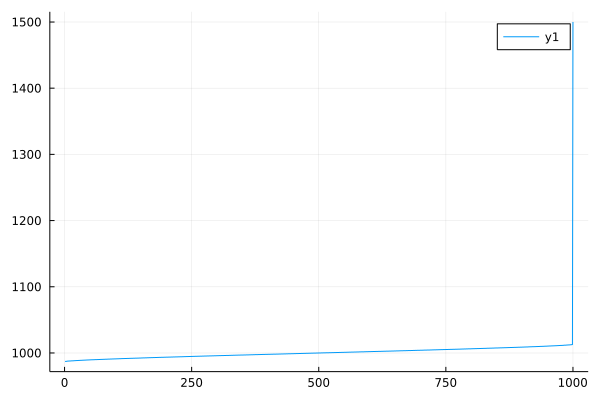

In [6]:
using Plots
A2_eigen = eigen(A2)
plot(A2_eigen.values)

There are ways to precondition $A$ so that the eigenvalues are clustered and our CGM terminates with relatively little itterations. They most important strategies are _symmetric successive overrelaxation (SSOR)_, _incomplete Cholesky_ (most effective in general), and _banded preconditioners_.

This concludes the notes on Linear Conjugate Gradient Methods.

## Non-Linear Conjugate Gradient Methods

It is relatively easy to extend the linear CGM method to be applied to a general nonlinear function $f$. The major challenge is that we no longer have an analytical formula for the one-dimensional minimization problem that provides our step length $\alpha$. Instead we must compute an $\alpha$ by performing one of the line-search schemes. Ideally, the choosen scheme satisfies the _Strong Wolfe conditions_ (with $0 < c_1< c_2 < \frac{1}{2}$) or _Goldstein conditions_ which converge for all reasonable guesses of $x_0$, such that f is twice differentiable, $\nabla^2$ is Lipschitz continuos in a Neighboorhood near $x^*$, and $f$ is bounded below (we are minimizing afterall). We must make one more update to our linear CGM to apply, namely, we no longer have a convient formula for $r$. Instead we must compute the nonlinear gradient to determine our residual, $r$. Making these minor updates, by the work of Fletcher and Reeves, leads to our first nonlinear conjugate gradient method.


***function cgm_fr($f$, $x_0$, $\epsilon$):*** The first argument is $f : \mathbb{R^n} \rightarrow \mathbb{R}$ where $f$ is bounded below, $f$ is twice differentiable, and $\nabla f^2$ is Lipschitz continuous near $x^*$. Then $x_0$ is a reasonable guess of a global minimizer $x^*$ and $\epsilon$ is a specified precision and termination condition. Upon termination, the algorithm produces an estimate of $x^*$. The function uses ForwardDiff.jl to calculate an Automatic Differentiation estimate of $\nabla f_k(x_k)$. 

Note: current implementation not working well

***function line_search_backtrack($f$,  $\nabla f(x_k)$,  $\nabla f(x_k)^T p_k$,  $x_k$,  $\alpha_{k-1}$):*** Returns an estimate of $\alpha_k$, the solution to the one-dimensional minimization problem $\arg \min_\alpha f(x_k + \alpha_k p_k)$. It uses a crude backtracking approach that **does not** satisfy the Strong Wolfe Conditions

In [36]:
using ForwardDiff;

function cgm_fr(f, x, eps)
    fx  = f(x) # TODO determine from ForwardDiff.gradient call
    df  = (dx) -> ForwardDiff.gradient(f, dx)
    dfx = df(x)
    p   = -dfx
    k   = 0
    a   = 1
    while (r = norm(dfx)) > eps
        dfx_old = dfx
        a = line_search_backtrack(f, fx, dfx_old'*p, x, p, a)
        x += a*p
        dfx = df(x)
        p = -dfx + (dfx'*dfx)/(dfx_old'*dfx_old)*p
        # NOTE: trying to normalize p here leads to strange behavior
        isdisaster(k+=1,1000)
    end
    x
end

function line_search_backtrack(f, fx, dfp, x, p, a)
    rho = 0.5
    c = 10^(-2)
    while f(x + a*p) > fx + c*a*dfp
        a *=rho
    end
    a
end


line_search_backtrack (generic function with 2 methods)

In [37]:
function rosen(x)
    fVal = 0.0
    for i in 1:length(x)-1
        fVal += 100.0*(x[i+1] - x[i]^2)^2 + (1.0-x[i])^2
    end
    return fVal
end



rosen (generic function with 1 method)

In [40]:
cgm_fr(rosen, [1.2, 1.2, 1.2, 1.2], 10^(-4))

4-element Vector{Float64}:
 1.0000216600189409
 1.0000434010372377
 1.0000869803633476
 1.000174377592519

The above algorithm is not working proerply, I believe that **cgm_fr( $\cdot$ )** is free of issues but I need to work on implementing a line search that appropriately selects the best step size. That is, an $\alpha_k$ that corresponds to $\arg \min_\alpha f(x_k + \alpha_k p_k)$. Furthermore, it is possible that my issues lie in the fact that $p_k$ may not actually be a direction of descent.

